In [1]:
import pandas as pd

In [2]:
temp = pd.read_csv('clean.csv')

In [3]:
temp

,userID,itemID,category,behavior,date,time
0,1,2576651,149192,pv,2017-11-25,01:21:25
1,1,3830808,4181361,pv,2017-11-25,07:04:53
2,1,4365585,2520377,pv,2017-11-25,07:49:06
3,1,4606018,2735466,pv,2017-11-25,13:28:01
4,1,230380,411153,pv,2017-11-25,21:22:22
...,...,...,...,...,...,...
98914479,999999,4797808,11120,pv,2017-12-03,09:30:03
98914480,999999,4613472,4602841,pv,2017-12-03,09:36:06
98914481,999999,3647364,2304296,pv,2017-12-03,09:36:32
98914482,999999,1903801,2304296,pv,2017-12-03,09:37:07


##### 5.1 User jouney ( individul )

In [4]:
behavior_counts = temp.groupby(['userID', 'behavior']).size().unstack(fill_value=0)

In [5]:
behavior_counts

behavior,buy,cart,fav,pv
userID,,,,
1,0,0,0,53
2,7,3,7,54
3,0,15,5,33
4,4,13,0,268
5,0,0,0,64
...,...,...,...,...
1018007,0,0,1,161
1018008,0,0,17,32
1018009,2,21,2,286


In [59]:
### if count(user behavior) == 0, an eps is needed, otherwise a NaN would be recieved
eps = 1e-10

pv_to_buy_rate = (behavior_counts['buy']+eps) / (behavior_counts['pv']+eps)
pv_to_cart_or_fav_rate = (behavior_counts['cart'] + behavior_counts['fav']+eps) / (behavior_counts['pv']+eps)
# cart_or_fav_to_buy_rate = (behavior_counts['buy']+eps) / (behavior_counts['cart'] + behavior_counts['fav']+eps)

# there would be a special situation when count(cart+fav)==0
cart_or_fav_to_buy_rate = behavior_counts.apply(
    lambda row: (row['buy'] / (row['cart'] + row['fav'])) 
    if (row['cart'] + row['fav']) > 0 else 0, axis=1)

In [60]:
conversion_rates = pd.DataFrame({
    'pv_to_cart/fav_rate': pv_to_cart_or_fav_rate,
    'cart/fav_to_buy_rate': cart_or_fav_to_buy_rate,
    'pv_to_buy_rate': pv_to_buy_rate
})

In [61]:
conversion_rates = conversion_rates.applymap(lambda x: f"{x:.2%}") # f"{x:.4f}"
conversion_rates

,pv_to_cart/fav_rate,cart/fav_to_buy_rate,pv_to_buy_rate
userID,,,
1,0.00%,0.00%,0.00%
2,18.52%,70.00%,12.96%
3,60.61%,0.00%,0.00%
4,4.85%,30.77%,1.49%
5,0.00%,0.00%,0.00%
...,...,...,...
1018007,0.62%,0.00%,0.00%
1018008,53.13%,0.00%,0.00%
1018009,8.04%,8.70%,0.70%


###### 5.2 User jouney ( total )

In [62]:
behavior_total_counts = temp['behavior'].value_counts()

In [72]:
behavior_total_counts

pv      88596886
cart     5466118
fav      2852536
buy      1998944
Name: behavior, dtype: int64

In [84]:
stages = {
    'PageView': behavior_total_counts.get('pv', 0),
    'AddToCart': behavior_total_counts.get('cart', 0),
    'AddToFav': behavior_total_counts.get('fav', 0),
    'Bought': behavior_total_counts.get('buy', 0)
}


In [85]:
stages['CartAndFav'] = stages['AddToCart'] + stages['AddToFav']
del stages['AddToCart'],stages['AddToFav']

In [87]:
funnel_order = ['PageView', 'CartAndFav', 'Bought']

funnel_data = {stage: stages[stage] for stage in funnel_order}
funnel_stages = list(funnel_data.keys())
funnel_values = list(funnel_data.values())

# get percent value, based on pv
funnel_percentages = [value / funnel_values[0] * 100 for value in funnel_values]

In [95]:
funnel_data

{'PageView': 88596886, 'CartAndFav': 8318654, 'Bought': 1998944}

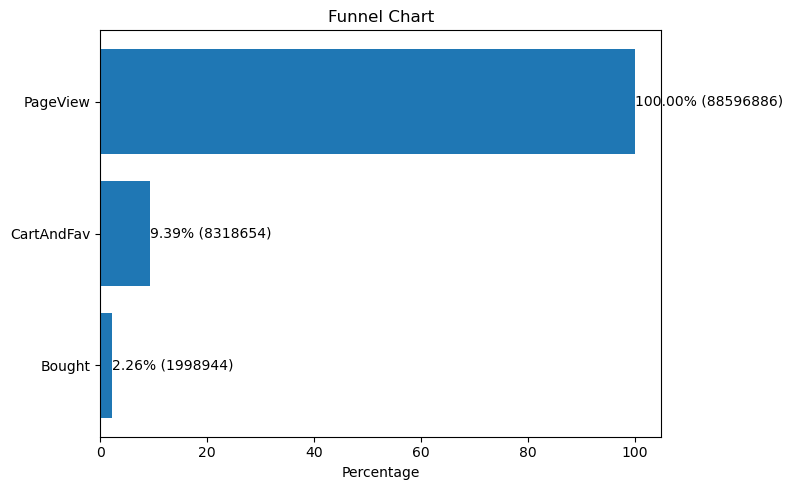

In [94]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8, 5))

y_pos = range(len(funnel_stages))

bars = ax.barh(y_pos, funnel_percentages, align='center')

# reserve
ax.set_yticks(y_pos)
ax.set_yticklabels(funnel_stages)
ax.invert_yaxis()

for bar, percentage, value in zip(bars, funnel_percentages, funnel_values):
    text = f"{percentage:.2f}% ({value})"
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, text,
             va='center', ha='left')

ax.set_xlabel('Percentage')
ax.set_title('Funnel Chart')

plt.tight_layout()
plt.show()

In [99]:
import plotly.graph_objects as go

# Create the funnel chart
fig = go.Figure(go.Funnel(
    y=funnel_stages,
    x=funnel_values,
    text=[f"{val} ({perc:.2f}%)" for val, perc in zip(funnel_values, funnel_percentages)],
    textinfo="text+value"
))

# Customize layout, if desired
fig.update_layout(
    title="User Behavior Funnel",
    funnelmode="stack",  # This stacks the funnel sections on top of each other
)

# Show the figure
fig.show()

###### 6. Repurchase Rate

In [103]:
temp2 = temp[temp["behavior"]=="buy"]

In [109]:
user_bought_counts = temp2.groupby('userID').size()
repurchase_users = user_bought_counts[user_bought_counts > 1]
repurchase_rate = len(repurchase_users) / len(user_bought_counts)

print(f"There are {len(user_bought_counts)} users in total and {len(repurchase_users)} repurchase users")
print(f"The Repurchase Rate is {repurchase_rate:.4f} or {repurchase_rate * 100:.2f}%")

There are 670370 users in total and 441196 repurchase users
The Repurchase Rate is 0.6581 or 65.81%


###### 7. RFM model
######  ### Due to the lack of M records, only R and F are considered

In [117]:
purchase_counts = temp2.groupby('userID').size()

# Calculate the average purchase frequency per user
average_purchase_frequency = purchase_counts.mean()

# Calculate the median purchase frequency per user
median_purchase_frequency = purchase_counts.median()

print(f"Average purchase frequency per user: {average_purchase_frequency}")
print(f"Median purchase frequency per user: {median_purchase_frequency}")

Average purchase frequency per user: 2.9818518131777974
Median purchase frequency per user: 2.0


In [176]:
from datetime import datetime

temp2['date'] = pd.to_datetime(temp2['date'])
current_date = temp2['date'].max() + pd.Timedelta(days=1)

# R: Recency
recency_df = temp2.groupby('userID')['date'].max().reset_index()
recency_df['Recency'] = (current_date - recency_df['date']).dt.days

# F: Frequency
frequency_df = temp2[temp2['behavior'] == 'buy'].groupby('userID')['date'].count().reset_index()
frequency_df.rename(columns={'date': 'Frequency'}, inplace=True)

C:\Users\Yummy\AppData\Local\Temp\ipykernel_8724\42196940.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [177]:
recency_df

,userID,date,Recency
0,2,2017-12-02,2
1,4,2017-11-30,4
2,11,2017-11-25,9
3,16,2017-12-01,3
4,17,2017-12-01,3
...,...,...,...
670365,1017999,2017-12-02,2
670366,1018002,2017-12-03,1
670367,1018009,2017-12-01,3
670368,1018010,2017-12-02,2


In [178]:
frequency_df

,userID,Frequency
0,2,7
1,4,4
2,11,1
3,16,2
4,17,1
...,...,...
670365,1017999,8
670366,1018002,2
670367,1018009,2
670368,1018010,6


In [179]:
rf_df = pd.merge(recency_df[['userID', 'Recency']], frequency_df, on='userID', how='left')

###
rf_df['Frequency'].fillna(0, inplace=True)

In [201]:
def r_score(x):
    if x <= 1:
        return 6
    elif x<= 2:
        return 5
    elif x <= 4:
        return 4
    elif x <= 6:
        return 3
    elif x <= 8:
        return 2
    else:
        return 1

def f_score(x):
    if x <= 2:
        return 1
    elif x <= 4:
        return 2
    elif x <= 6:
        return 3
    elif x <= 8:
        return 4
    else:
        return 5
    

rf_df['R_score'] = rf_df['Recency'].apply(r_score)
rf_df['F_score'] = rf_df['Frequency'].apply(f_score)

r_score_avg = rf_df['R_score'].mean()
f_score_avg = rf_df['F_score'].mean()

rf_df['User_Segment'] = rf_df.apply(lambda x: 'Best Customers' if x['R_score'] > r_score_avg and x['F_score'] > f_score_avg
                                     else 'Potential Loyalist' if x['R_score'] <= r_score_avg and x['F_score'] > f_score_avg
                                     else 'Needing Attention' if x['R_score'] > r_score_avg and x['F_score'] <= f_score_avg
                                     else 'About to Sleep', axis=1)

print(r_score_avg)
print(f_score_avg)

print(rf_df[['userID', 'R_score', 'F_score', 'User_Segment']])


4.152791741873891
1.7270358160418873
         userID  R_score  F_score        User_Segment
0             2        5        4      Best Customers
1             4        4        2  Potential Loyalist
2            11        1        1      About to Sleep
3            16        4        1      About to Sleep
4            17        4        1      About to Sleep
...         ...      ...      ...                 ...
670365  1017999        5        4      Best Customers
670366  1018002        6        1   Needing Attention
670367  1018009        4        1      About to Sleep
670368  1018010        5        3      Best Customers
670369  1018011        2        1      About to Sleep

[670370 rows x 4 columns]


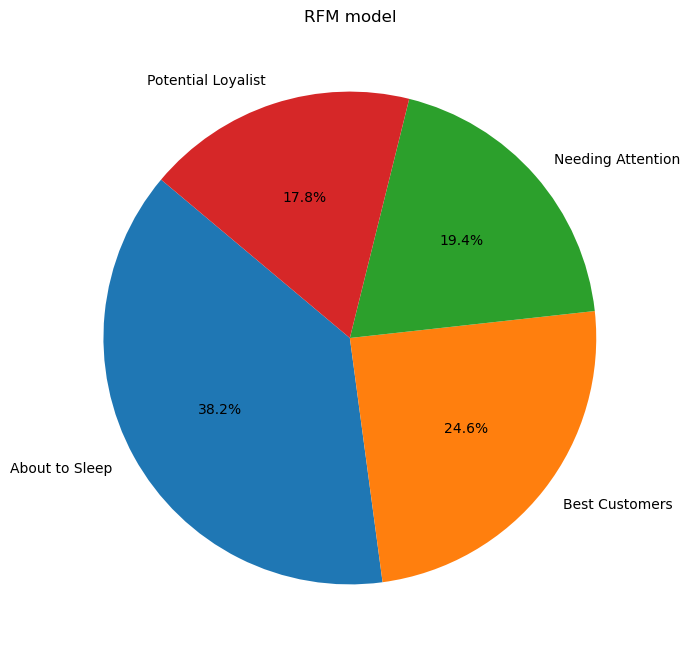

In [202]:
# 假设rf_df是你已经分好类的DataFrame
user_segments_counts = rf_df['User_Segment'].value_counts()

# pie chart
plt.figure(figsize=(10, 8))
plt.pie(user_segments_counts, labels=user_segments_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('RFM model')
plt.show()


In [203]:
rf_df

,userID,Recency,Frequency,R_score,F_score,User_Segment
0,2,2,7,5,4,Best Customers
1,4,4,4,4,2,Potential Loyalist
2,11,9,1,1,1,About to Sleep
3,16,3,2,4,1,About to Sleep
4,17,3,1,4,1,About to Sleep
...,...,...,...,...,...,...
670365,1017999,2,8,5,4,Best Customers
670366,1018002,1,2,6,1,Needing Attention
670367,1018009,3,2,4,1,About to Sleep
670368,1018010,2,6,5,3,Best Customers


###### 8. Average Order Value (???)
###### ### it was asked for users/items average value, But I feel that distributing based on time is more meaningful.

In [204]:
total_pv = temp[temp['behavior'] == 'pv'].shape[0]
total_buy = temp2.shape[0]
total_users = temp['userID'].nunique()

In [208]:
print(f"total count of  page views count is: {total_pv}")
print(f"total count of users is: {total_users}")
print(f"total count of purchases is: {total_buy}")
print(f"the average page views per user is: {round(total_pv / total_users,4)}")
print(f"the average purchases per user is: {round(total_buy / total_users,4)}")

total count of  page views count is: 88596886
total count of users is: 987984
total count of purchases is: 1998944
the average page views per user is: 89.6744
the average purchases per user is: 2.0233


In [209]:
daily_pv = temp[temp['behavior'] == 'pv'].groupby('date')['userID'].count().reset_index(name='total_pv_per_day')
daily_buy = temp[temp['behavior'] == 'buy'].groupby('date')['userID'].count().reset_index(name='total_buy_per_day')
daily_users = temp.groupby('date')['userID'].nunique().reset_index(name='total_users_per_day')


In [210]:
daily_data = pd.merge(daily_pv, daily_buy, on='date')
daily_data = pd.merge(daily_data, daily_users, on='date')


In [211]:
daily_data['average_page_views_per_user_per_day'] = daily_data['total_pv_per_day'] / daily_data['total_users_per_day']
daily_data['average_purchases_per_user_per_day'] = daily_data['total_buy_per_day'] / daily_data['total_users_per_day']


In [212]:
daily_data = daily_data[['date', 'total_buy_per_day', 'total_users_per_day', 'average_page_views_per_user_per_day', 'average_purchases_per_user_per_day']]


In [213]:
daily_data

,date,total_buy_per_day,total_users_per_day,average_page_views_per_user_per_day,average_purchases_per_user_per_day
0,2017-11-25,201297,705571,13.372503,0.285297
1,2017-11-26,214308,713522,13.280024,0.300352
2,2017-11-27,218401,709207,12.642894,0.307951
3,2017-11-28,211754,708339,12.492878,0.298944
4,2017-11-29,223077,719356,12.847113,0.310107
5,2017-11-30,222235,730809,12.919928,0.304095
6,2017-12-01,212849,753166,13.280318,0.282606
7,2017-12-02,259550,941709,13.247409,0.275616
8,2017-12-03,235473,917531,11.671855,0.256638


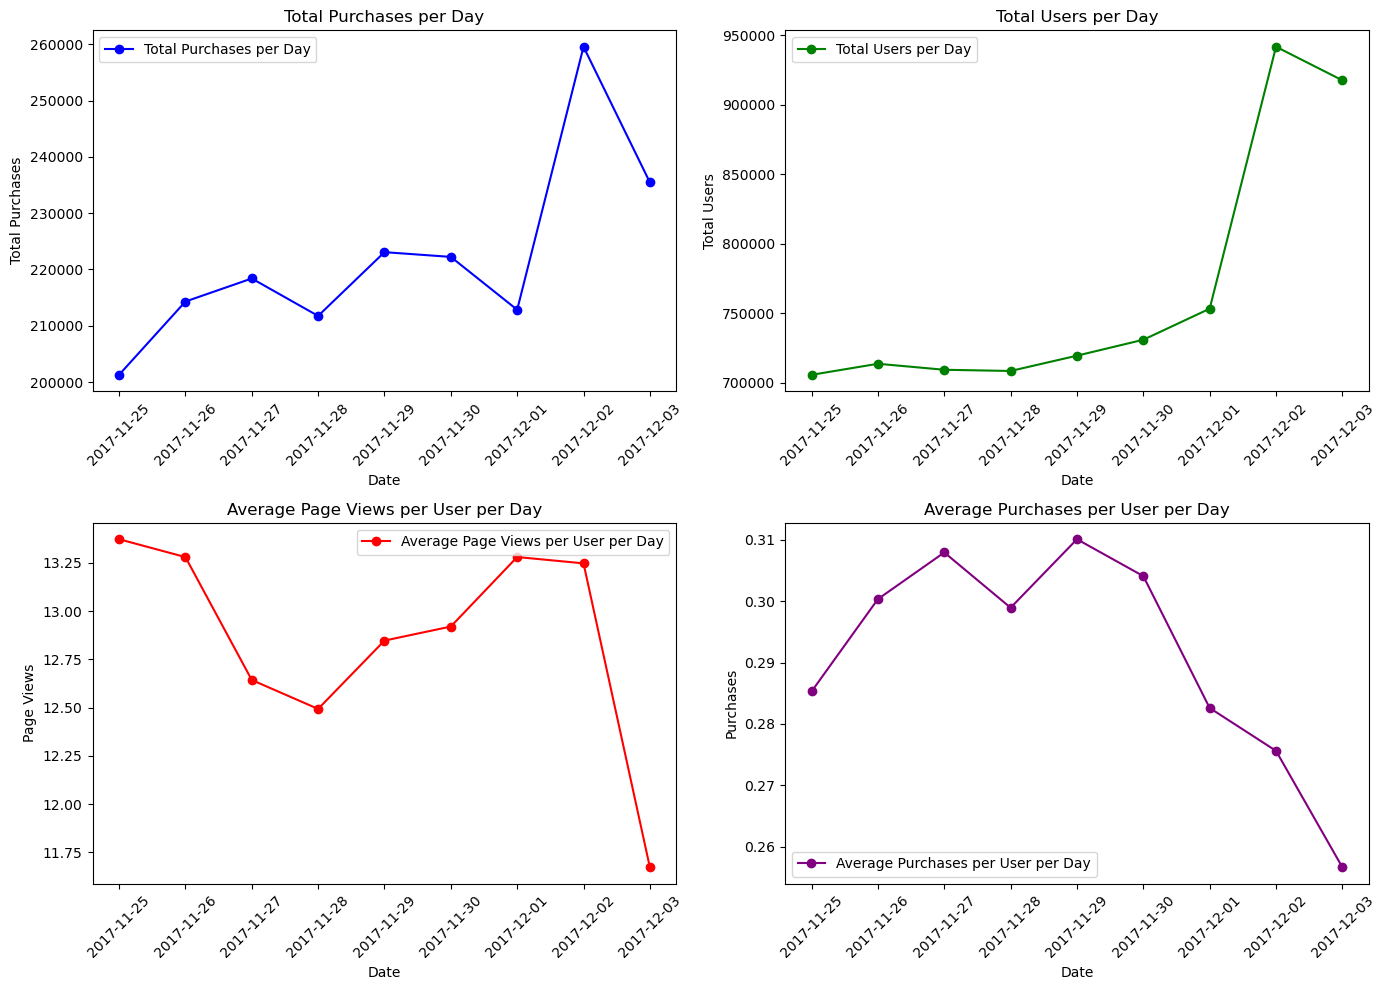

In [214]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)  
plt.plot(daily_data['date'], daily_data['total_buy_per_day'], marker='o', color='blue', label='Total Purchases per Day')
plt.xticks(rotation=45)  
plt.title('Total Purchases per Day')
plt.xlabel('Date')
plt.ylabel('Total Purchases')
plt.legend()

plt.subplot(2, 2, 2)  
plt.plot(daily_data['date'], daily_data['total_users_per_day'], marker='o', color='green', label='Total Users per Day')
plt.xticks(rotation=45)
plt.title('Total Users per Day')
plt.xlabel('Date')
plt.ylabel('Total Users')
plt.legend()

plt.subplot(2, 2, 3)  
plt.plot(daily_data['date'], daily_data['average_page_views_per_user_per_day'], marker='o', color='red', label='Average Page Views per User per Day')
plt.xticks(rotation=45)
plt.title('Average Page Views per User per Day')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.legend()

plt.subplot(2, 2, 4)  
plt.plot(daily_data['date'], daily_data['average_purchases_per_user_per_day'], marker='o', color='purple', label='Average Purchases per User per Day')
plt.xticks(rotation=45)
plt.title('Average Purchases per User per Day')
plt.xlabel('Date')
plt.ylabel('Purchases')
plt.legend()

plt.tight_layout()
plt.show()
